In [23]:
import math
import json
import numpy as np
from collections import Counter

import torch
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import plotly.graph_objects as go

from tqdm import tqdm

from nano_bert.model import BertMix3
from nano_bert.tokenizer import WordTokenizer
torch.manual_seed(114514)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
data = None
with open('data/imdb_train.json') as f:
    data = [json.loads(l) for l in f.readlines()]

In [3]:
test_data = None
with open('data/imdb_test.json') as f:
    test_data = [json.loads(l) for l in f.readlines()]

In [4]:
rawvocab = [] # whole vocab
for d in tqdm(data): 
    rawvocab.append([w.lower() for w in d['text']]) # symbol like '.' is remained
vocab = set() # vocab for words appear more than 2 times(minappear = 2)
minappear = 2
for v in tqdm(rawvocab):
    if rawvocab.count(v) > minappear - 1:
        vocab |= set(v)

100%|██████████████████████████████████████████████████████████████████████████| 25000/25000 [00:03<00:00, 6290.74it/s]


In [5]:
def encode_label(label):
    if label == 'pos':
        return 1
    elif label == 'neg':
        return 0
    raise Exception(f'Unknown Label: {label}!')


class IMDBDataloader:
    def __init__(self, data, test_data, tokenizer, label_encoder, batch_size, val_frac=0.2):
        train_data, val_data = train_test_split(data, shuffle=True, random_state=1, test_size=val_frac)

        self.splits = {
            'train': [d['text'] for d in train_data],
            'test': [d['text'] for d in test_data],
            'val': [d['text'] for d in val_data]
        }

        self.labels = {
            'train': [d['label'] for d in train_data],
            'test': [d['label'] for d in test_data],
            'val': [d['label'] for d in val_data]
        }

        self.tokenized = {
            'train': [tokenizer(record).unsqueeze(0) for record in
                      tqdm(self.splits['train'], desc='Train Tokenization',position=0)], # divide different sentences in comments
            'test': [tokenizer(record).unsqueeze(0) for record in tqdm(self.splits['test'], desc='Test Tokenization',position=0)],
            'val': [tokenizer(record).unsqueeze(0) for record in tqdm(self.splits['val'], desc='Val Tokenization',position=0)],
        }

        self.encoded_labels = {
            'train': [label_encoder(label) for label in tqdm(self.labels['train'], desc='Train Label Encoding',position=0)],
            'test': [label_encoder(label) for label in tqdm(self.labels['test'], desc='Test Label Encoding',position=0)],
            'val': [label_encoder(label) for label in tqdm(self.labels['val'], desc='Val Label Encoding',position=0)],
        }

        self.curr_batch = 0
        self.batch_size = batch_size
        self.iterate_split = None

    def peek(self, split):
        return {
            'input_ids': self.splits[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)],
            'label_ids': self.labels[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)],
        }

    def take(self, split):
        batch = self.splits[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)]
        labels = self.labels[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)]
        self.curr_batch += 1
        return {
            'input_ids': batch,
            'label_ids': labels,
        }

    def peek_tokenized(self, split):
        return {
            'input_ids': torch.cat(
                self.tokenized[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)],
                dim=0),
            'label_ids': torch.tensor(
                self.encoded_labels[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)],
                dtype=torch.long),
        }

    def peek_index_tokenized(self, index, split):
        return {
            'input_ids': torch.cat(
                [self.tokenized[split][index]],
                dim=0),
            'label_ids': torch.tensor(
                [self.encoded_labels[split][index]],
                dtype=torch.long),
        }

    def peek_index(self, index, split):
        return {
            'input_ids': [self.splits[split][index]],
            'label_ids': [self.labels[split][index]],
        }

    def take_tokenized(self, split):
        batch = self.tokenized[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)]
        labels = self.encoded_labels[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)]
        self.curr_batch += 1
        return {
            'input_ids': torch.cat(batch, dim=0),
            'label_ids': torch.tensor(labels, dtype=torch.long),
        }

    def get_split(self, split):
        self.iterate_split = split
        return self

    def steps(self, split):
        return len(self.tokenized[split]) // self.batch_size

    def __iter__(self):
        self.reset()
        return self

    def __next__(self):
        if self.batch_size * self.curr_batch < len(self.splits[self.iterate_split]):
            return self.take_tokenized(self.iterate_split)
        else:
            raise StopIteration

    def reset(self):
        self.curr_batch = 0

In [6]:
NUM_CLASS = 2
BATCH_SIZE = 4
MAX_SEQ_LEN = 128
LEARNING_RATE = 1e-4

In [7]:
vocab.discard('.') # '.' is included in taken's vocab enumerate
tokenizer = WordTokenizer(vocab=vocab, max_seq_len=MAX_SEQ_LEN)
tokenizer

Tokenizer[vocab=3665,self.special_tokens=['[MSK]', '[PAD]', '[CLS]', '[SEP]', '[UNK]', '[SOS]', '.'],self.sep=' ',self.max_seq_len=128]

In [8]:
dataloader = IMDBDataloader(data, test_data, tokenizer, encode_label, batch_size=BATCH_SIZE)

Val Label Encoding: 100%|██████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 567043.05it/s]


In [9]:
bert = BertMix3(
    vocab_size=len(tokenizer.vocab),
    n_layers=2,
    n_heads=1,
    max_seq_len=MAX_SEQ_LEN,
    n_classes=NUM_CLASS,
    n_embed = 4
).to(device)
bert

BertMix3(
  (nano_bert): NanoBERT(
    (embedding): BertEmbeddings(
      (word_embeddings): Embedding(3665, 4)
      (pos_embeddings): Embedding(128, 4)
      (layer_norm): LayerNorm((4,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layers): ModuleList(
        (0-1): 2 x BertLayer(
          (layer_norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
          (self_attention): BertSelfAttention(
            (heads): ModuleList(
              (0): BertAttentionHead(
                (query): Linear(in_features=4, out_features=4, bias=True)
                (key): Linear(in_features=4, out_features=4, bias=True)
                (values): Linear(in_features=4, out_features=4, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
            )
            (proj): Linear(in_features=4, out_features=4, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
count_parameters(bert)

34033

In [12]:
dataloader.steps('train')
dataloader.get_split('train')

In [13]:
import random
def mask_text(cmt, vacab_size): # cmt : a comment
    mps = []
    mcmt = cmt.clone()
    unique_elements, counts = torch.unique(cudata[i], return_counts=True)
    n_sp = len(tokenizer.special_tokens) # number of special_tokens = 7
    m_range = (MAX_SEQ_LEN - counts[0].item()) * 0.15 # range of masking indice
#     print(m_range, counts[0].item())
    while len(mps) < m_range:
        temp = random.randint(0, MAX_SEQ_LEN - 1)
        if mcmt[temp] > n_sp - 1:
            mps.append(temp)
            mcmt[temp] = 0 # set to mask
    temp_m = random.sample(range(0, len(mps) - 1), 2 * int(m_range * 0.1 + 1)) # fetch some masked words to their original value
    half = int(len(temp_m)/2)
    tmps = torch.tensor(mps) # tensorlize mps to get location of masks to be changed
    mcmt[tmps[temp_m[:half]]] = cmt[temp_m[:half]] # 10% percent original
    mcmt[tmps[temp_m[half:]]] = torch.tensor([random.randint(n_sp, vacab_size - 1) for i in range(half)]).to(device) # 10% percent random vocab
    return mps, mcmt


In [15]:
def spit_cmt(cmt): # split  comment into sentences
    bg = torch.where(cmt==5)[0] # begin at '[SOS]'
    ed = torch.where(cmt==6)[0] # end at '.'
    spit = []
    n_st = len(bg) # number of next sentence prediction task in this comment
    for i in range(n_st):
        sts = cmt[bg[i].item():ed[i].item()+1]
        spit.append(sts)
    return spit, n_st
def pad_nsp(nsp, max_seq_len): # add '[CLS]' and padding on given composed 2 sentences in GPU
#     print('len nsp = ', len(nsp))
    return (torch.cat((torch.cat((torch.tensor([0]).to(device), nsp), 0), torch.ones(max_seq_len - len(nsp) - 1).to(device)), 0))
def nsp_gen(spit, n_st, max_seq_len): # generate nsp input      
    nsp = torch.zeros((2 * (n_st - 1), max_seq_len)).to(device)
    if n_st < 3:
        nsp = torch.zeros((1, max_seq_len)).to(device)
#     print(nsp[:10], n_st)
    for id_i in range(n_st - 1):
        nsp[2 * id_i] = pad_nsp(torch.cat((spit[id_i], spit[id_i + 1]), 0), max_seq_len) # a sentence followed by the next
        if n_st > 2:
            id_s = random.randint(0, n_st - 1) # selected id for nsp
            while id_s == id_i + 1 or id_s == id_i: # excluded the next sentence
                id_s = random.randint(0, n_st - 1)
            nsp[2 * id_i + 1] = pad_nsp(torch.cat((spit[id_i], spit[id_s]), 0), max_seq_len) # a sentence not followed by the next
    return nsp.long().to(device)

In [16]:
history_pretrain = {
    'train_losses': [],
    'val_losses': [],
    'train_acc': [],
    'val_acc': [],
    'train_f1': [],
    'val_f1': []
}
history = {
    'train_losses': [],
    'val_losses': [],
    'train_acc': [],
    'val_acc': [],
    'train_f1': [],
    'val_f1': []
}

### pretrain task, 25 min/epoch

In [35]:
optimizer = torch.optim.Adam(bert.parameters(), lr=LEARNING_RATE)
NUM_EPOCHS = 10 # epochs for pretrain task
vacab_size = len(tokenizer.vocab)
for i in range(NUM_EPOCHS):
    print(f'Epoch: {i + 1}')
    train_loss = 0.0

    bert.train()
    for step, batch in enumerate(tqdm(dataloader.get_split('train'), total=dataloader.steps('train'), position=0)):
        loss = 0
        cudata = batch['input_ids'].to(device) # put the dat in the whole batch to gpu
        # MLM part
        for i in range(len(cudata)): # BATCH_SIZE = len(cudata)
            mps, mcmt = mask_text(cudata[i], vacab_size)
            lmps = len(mps)
            _, r_mlm, _ = bert(mcmt.unsqueeze(dim=0)) # (Batch, Seq_Len, len(vocab))
            MCMT = r_mlm[0][mps, :] # fectch the predicted value from masked input
            predm = cudata[i][mps].long() # fectch the real word correspond to the masked input
            for i in range(lmps):
                loss += F.cross_entropy(MCMT.to(device), predm.to(device)) / lmps
        
        # NSP part
        for i in range(len(cudata)): 
            spit, n_st = spit_cmt(cudata[i]) # (Batch, Seq_Len, len(vocab)), number of sentences
            if n_st > 1: # calculate NSP loss if a comment has more than 1 sentence
                predn = torch.tensor([1, 0] * (n_st - 1)).to(device) # label of next/not next composed sentences
                if n_st < 3:
                    predn = torch.tensor([1]).to(device)
                _, _, r_nsp = bert(nsp_gen(spit, n_st, MAX_SEQ_LEN))
    #             print(n_st)
    #             print(r_nsp[:, 0, :].shape, predn.shape)
    #             print(r_nsp[:, 0, :], predn)
                loss +=  F.cross_entropy(r_nsp[:, 0, :], predn)
        print(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item()
    history_pretrain['train_losses'].append(train_loss / dataloader.steps("train"))
    val_loss = 0.0

Epoch: 1


  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

287.7297058105469


  0%|▏                                                                                 | 1/625 [00:02<23:51,  2.29s/it]

287.8255920410156


  0%|▎                                                                                 | 2/625 [00:04<25:02,  2.41s/it]

287.5476379394531


  0%|▍                                                                                 | 3/625 [00:07<25:15,  2.44s/it]

287.0135498046875


  1%|▌                                                                                 | 4/625 [00:09<25:19,  2.45s/it]

288.1851501464844


  1%|▋                                                                                 | 5/625 [00:12<25:21,  2.45s/it]

286.33648681640625


  1%|▊                                                                                 | 6/625 [00:14<25:02,  2.43s/it]

287.5586242675781


  1%|▉                                                                                 | 7/625 [00:16<24:46,  2.41s/it]

288.1275329589844


  1%|█                                                                                 | 8/625 [00:19<24:51,  2.42s/it]

288.6780090332031


  1%|█▏                                                                                | 9/625 [00:21<24:51,  2.42s/it]

288.0267639160156


  2%|█▎                                                                               | 10/625 [00:24<25:08,  2.45s/it]

287.9959716796875


  2%|█▍                                                                               | 11/625 [00:26<25:05,  2.45s/it]

287.7472229003906


  2%|█▌                                                                               | 12/625 [00:29<25:19,  2.48s/it]

286.1722106933594


  2%|█▋                                                                               | 13/625 [00:31<24:52,  2.44s/it]

287.9275817871094


  2%|█▊                                                                               | 14/625 [00:33<24:24,  2.40s/it]

285.74169921875


  2%|█▉                                                                               | 15/625 [00:36<24:12,  2.38s/it]

287.5697021484375


  2%|█▉                                                                               | 15/625 [00:38<26:13,  2.58s/it]


KeyboardInterrupt: 

In [18]:
PATH = 'imdb_pre_para.pth'# parameter for pretrain task
torch.save(bert.state_dict(), PATH)

### Fine-tuning on text classification downstream task, 20s/epoch

In [31]:
BATCH_SIZE_F = 32

In [32]:
dataloader_F = IMDBDataloader(data, test_data, tokenizer, encode_label, batch_size=BATCH_SIZE_F)

Val Label Encoding: 100%|██████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 900529.03it/s]


In [33]:
NUM_EPOCHS_F = 100

for i in range(NUM_EPOCHS_F):
    print(f'Epoch: {i + 1}')
    train_loss = 0.0
    train_preds = []
    train_labels = []

    bert.train()
    for step, batch in enumerate(tqdm(dataloader_F.get_split('train'), total=dataloader_F.steps('train'))):
        r_cls, _, _ = bert(batch['input_ids'].to(device)) # (B, Seq_Len, 2)

        probs = F.softmax(r_cls[:, 0, :], dim=-1).cpu()# fetch the result from the first word in the text as output
        pred = torch.argmax(probs, dim=-1) # (B)
        train_preds += pred.detach().tolist()
        train_labels += [l.item() for l in batch['label_ids']]

        loss = F.cross_entropy(r_cls[:, 0, :].cpu(), batch['label_ids'])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    val_loss = 0.0
    val_preds = []
    val_labels = []

    bert.eval()
    for step, batch in enumerate(tqdm(dataloader.get_split('val'), total=dataloader.steps('val'))):
        r_cls, _, _ = bert(batch['input_ids'].to(device))

        probs = F.softmax(r_cls[:, 0, :], dim=-1).cpu()
        pred = torch.argmax(probs, dim=-1) # (B)
        val_preds += pred.detach().tolist()
        val_labels += [l.item() for l in batch['label_ids']]

        loss = F.cross_entropy(r_cls[:, 0, :].cpu(), batch['label_ids'])

        val_loss += loss.item()

    history['train_losses'].append(train_loss)
    history['val_losses'].append(val_loss)
    history['train_acc'].append(accuracy_score(train_labels, train_preds))
    history['val_acc'].append(accuracy_score(val_labels, val_preds))
    history['train_f1'].append(f1_score(train_labels, train_preds))
    history['val_f1'].append(f1_score(val_labels, val_preds))

    print()
    print(f'Train loss: {train_loss / dataloader.steps("train")} | Val loss: {val_loss / dataloader.steps("val")}')
    print(f'Train acc: {accuracy_score(train_labels, train_preds)} | Val acc: {accuracy_score(val_labels, val_preds)}')
    print(f'Train f1: {f1_score(train_labels, train_preds)} | Val f1: {f1_score(val_labels, val_preds)}')

Epoch: 1


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:23<00:00, 26.15it/s]
157it [00:02, 76.22it/s]                                                                                               



Train loss: 0.6939166432380677 | Val loss: 0.697607050721462
Train acc: 0.49975 | Val acc: 0.5034
Train f1: 0.6647455014576282 | Val f1: 0.6696820540109086
Epoch: 2


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:23<00:00, 26.97it/s]
157it [00:02, 76.40it/s]                                                                                               



Train loss: 0.693553184890747 | Val loss: 0.6976215155460895
Train acc: 0.49845 | Val acc: 0.497
Train f1: 0.6041905062541925 | Val f1: 0.011787819253438114
Epoch: 3


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:22<00:00, 27.68it/s]
157it [00:02, 77.41it/s]                                                                                               



Train loss: 0.6933078657150269 | Val loss: 0.69767576838151
Train acc: 0.5052 | Val acc: 0.4966
Train f1: 0.48323759791122717 | Val f1: 0.0
Epoch: 4


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:22<00:00, 27.20it/s]
157it [00:01, 82.83it/s]                                                                                               



Train loss: 0.6931664058685303 | Val loss: 0.6977067230603634
Train acc: 0.5032 | Val acc: 0.4966
Train f1: 0.4246004169562196 | Val f1: 0.0
Epoch: 5


 28%|██████████████████████▊                                                         | 178/625 [00:05<00:14, 31.27it/s]


KeyboardInterrupt: 

In [24]:
PATH = 'imdb_tcl_para.pth'# parameter for text classification
torch.save(bert.state_dict(), PATH)

In [25]:
def plot_results(history, do_val=True):
    fig, ax = plt.subplots(figsize=(8, 8))

    x = list(range(0, len(history['train_losses'])))

    # loss

    ax.plot(x, history['train_losses'], label='train_loss')

    if do_val:
        ax.plot(x, history['val_losses'], label='val_loss')

    plt.title('Train / Validation Loss')
    plt.legend(loc='upper right')

    # accuracy

    fig, ax = plt.subplots(figsize=(8, 8))

    ax.plot(x, history['train_acc'], label='train_acc')

    if do_val:
        ax.plot(x, history['val_acc'], label='val_acc')

    plt.title('Train / Validation Accuracy')
    plt.legend(loc='upper right')

    # f1-score

    fig, ax = plt.subplots(figsize=(8, 8))

    ax.plot(x, history['train_f1'], label='train_f1')

    if do_val:
        ax.plot(x, history['val_f1'], label='val_f1')

    plt.title('Train / Validation F1')
    plt.legend(loc='upper right')

    fig.show()

C:\Users\HASEE\AppData\Local\Temp\ipykernel_16040\670068067.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


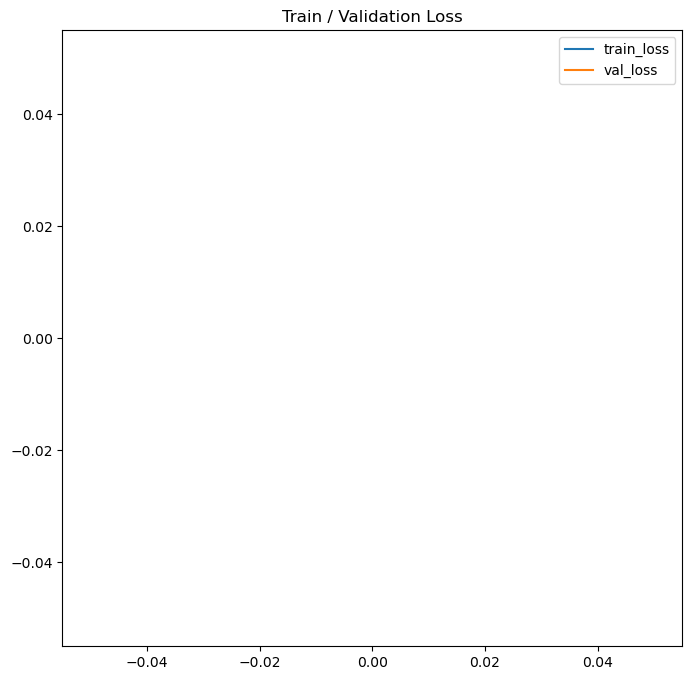

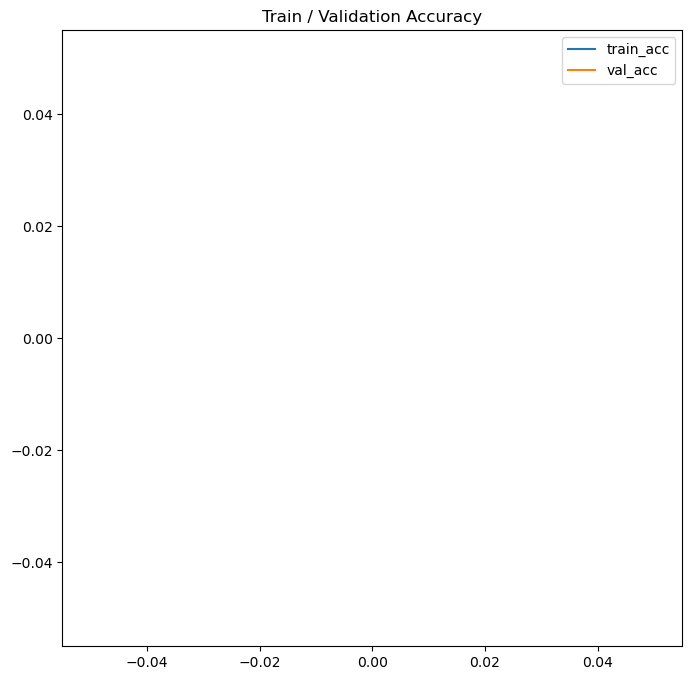

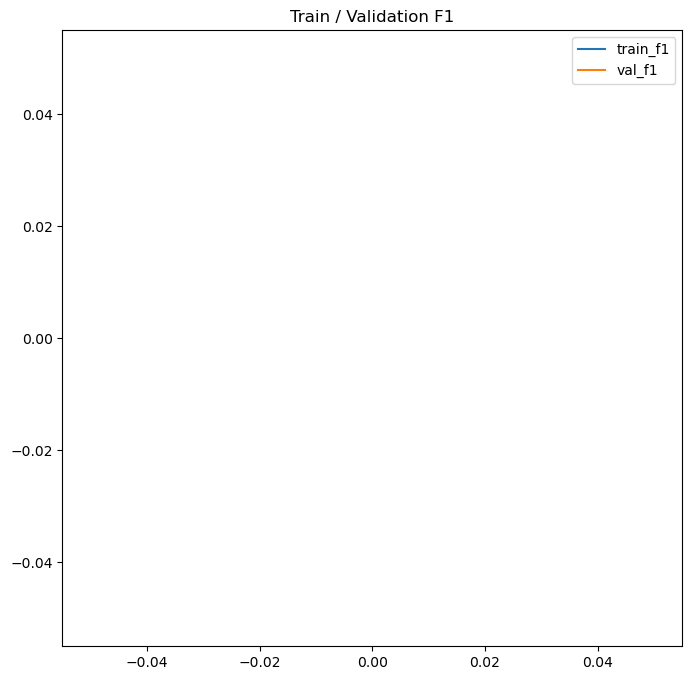

In [26]:
plot_results(history)

In [ ]:
test_loss = 0.0
test_preds = []
test_labels = []

bert.eval()
for step, batch in enumerate(tqdm(dataloader.get_split('test'), total=dataloader.steps('test'))):
    logits = bert(batch['input_ids'].to(device))

    probs = F.softmax(logits[:, 0, :], dim=-1).cpu()
    pred = torch.argmax(probs, dim=-1) # (B)
    test_preds += pred.detach().tolist()
    test_labels += [l.item() for l in batch['label_ids']]

    loss = F.cross_entropy(logits[:, 0, :].cpu(), batch['label_ids'])

    test_loss += loss.item()

print()
print(f'Test loss: {test_loss / dataloader.steps("test")}')
print(f'Test acc: {accuracy_score(test_labels, test_preds)}')
print(f'Test f1: {f1_score(test_labels, test_preds)}')

# Interpreting and visualizing the results

In [ ]:
def get_attention_scores(model, input_ids):
    """
    This is just a wrapper to easily access attention heads of the last layer
    """

    mask = (input_ids > 0).unsqueeze(1).repeat(1, input_ids.size(1), 1)

    embed = model.nano_bert.embedding(input_ids)

    # can be any layer, and we can also control what to do with output for each layer (aggregate, sum etc.)
    layer = model.nano_bert.encoder.layers[-1]

    x = layer.layer_norm1(embed)

    B, seq_len, n_embed = x.shape

    # if have more than 1 head, or interested in more than 1 head output just add aggregation here
    head = layer.self_attention.heads[0]

    # this is just a part of the single head that does all the computations (same code is present in AttentionHead)
    q = head.query(x)
    k = head.key(x)
    v = head.values(x)

    weights = (q @ k.transpose(-2, -1)) / math.sqrt(n_embed)  # (B, Seq_len, Seq_len)
    weights = weights.masked_fill(mask == 0, -1e9)  # mask out not attended tokens

    scores = F.softmax(weights, dim=-1)

    return scores

In [ ]:
test_dataloader = IMDBDataloader(data, test_data, tokenizer, encode_label, batch_size=1)

In [ ]:
def plot_parallel(matrix, tokens):
    # Set figsize
    plt.figure(figsize=(12, 8))

    input_len = len(tokens)

    # Vertical lines
    plt.axvline(x=1, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=5, color='black', linestyle='--', linewidth=1)

    # Add the A and B
    plt.text(1, input_len + 1, 'A', fontsize=12, color='black', fontweight='bold')
    plt.text(5, input_len + 1, 'B', fontsize=12, color='black', fontweight='bold')

    for i in range(input_len):
        for j in range(input_len):
            # Add the line to the plot
            plt.plot([1, 5], [i, j], marker='o', label='token', color='blue', linewidth=5 * matrix[i][j])

            plt.text(
                1 - 0.18,  # x-axis position
                i,  # y-axis position
                tokens[i],  # Text
                fontsize=8,  # Text size
                color='black',  # Text color,
            )

            plt.text(
                5 + 0.06,  # x-axis position
                j,  # y-axis position
                tokens[j],  # Text
                fontsize=8,  # Text size
                color='black',  # Text color
            )
        break

    plt.title(f'Attention scores \n\n\n')

    plt.yticks([])  # Remove y-axis
    plt.box(False)  # Remove the bounding box around plot
    plt.show()  # Display the chart

In [ ]:
# examples with less than 16 words are easier to visualize, so focus on them
examples_ids = []
for i, v in enumerate(test_dataloader.splits['test']):
    if len(v) <= 16:
        examples_ids.append(i)
print(examples_ids)

In [ ]:
for sample_index in examples_ids:
    # extract example, decode to tokens and get the sequence length (ingoring padding)
    test_tokenized_batch = test_dataloader.peek_index_tokenized(index=sample_index, split='test')
    tokens = tokenizer.decode([t.item() for t in test_tokenized_batch['input_ids'][0] if t != 0], ignore_special=False).split(' ')[:MAX_SEQ_LEN]
    seq_len = len(tokens)

    # calculate attention scores
    att_matrix = get_attention_scores(bert, test_tokenized_batch['input_ids'].to(device))[0, :seq_len, :seq_len]

    plot_parallel(att_matrix, tokens=tokens)